<a href="https://colab.research.google.com/github/tleitch/BDML/blob/main/Simple_end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lecture 4 -- Dealing with Data**
1. Remove and Impute Data 

2. Handling Categorical Data

3. Partitioning into training and test datasets

4. Dimensionality Reduction: Principal component analysis (PCA) 

5. Building a Pipeline

6. K-fold cross-validation

7. Learning/Validation curves
8. Grid Search

9. Confusion matrix/ROC-AUC curves

10. SMOTE

12. Homework Assignment 4

# **1. Remove and Impute Data**

Many times in practice your data may have missing values. In order to make your data useful certain key decisions will need to be made in the data cleaning process. Over time you will build your intuition on the optimal way to clean data. Often the right way will depend on the task at hand and how much data you have as well as the quality of your data. 

In [ ]:
# Identifying missing values in tabular data
import pandas as pd
from io import StringIO

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
,,,
5,,,8
3,4,5,6
10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df

In [ ]:
df.info()

In [ ]:
#use the isnull method to return a DataFrame with Boolean values that indicate whether a cell contains a numeric value (False) or if data is missing (True).
df.isnull().sum()

## **1.1 Eliminating training examples or features with missing values**

One of the easiest ways to deal with missing data is simply to remove the
corresponding features (columns) or training examples (rows) from the dataset
entirely; rows with missing values can easily be dropped via the dropna method

In [ ]:
df

In [ ]:
#Eliminating missing values

# Drop rows with missing value: (axis=0)
# df.dropna(axis=0)

# # Drop columns with missing value: (axis=1)
# df.dropna(axis=1)

# # only drop rows where all columns are NaN
# df.dropna(how='all')

# # need at least thresh# or more real values 
# df.dropna(thresh=3)

# # only drop rows where NaN appear in specific columns (here: 'C')
# df.dropna(subset=['C'])

## **1.2 Imputing missing values**

Often, the removal of training examples or dropping of entire feature columns
is simply not feasible, because we might lose too much valuable data. In this case,
we employ different interpolation techniques to estimate the missing values from
the other training examples in our dataset. One of the most common interpolation
techniques is mean imputation, simply replace the missing value with
the mean value of the entire feature column. A convenient way to achieve this is by
using the SimpleImputer class from scikit-learn, as shown in the following code

In [ ]:
# our original array
print(df)

#through Numpy
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df)
imputed_data = imr.transform(df)

print(imputed_data)

# Alternatively, an even more convenient way to impute missing values is by using pandas' fillna method
print(df.fillna(df.mean()))

In [ ]:
(3+5+12)/3

# **2. Handling Categorical data**

When we are talking about categorical data, we have to further distinguish between
ordinal and nominal features. Ordinal features can be understood as categorical
values that can be ordered or sorted. In contrast, nominal features
do not imply any order.

In [ ]:
import pandas as pd

df = pd.DataFrame([['green', 'M',  10.1, 'classA'],
                   ['red',   'L',  13.5, 'classB'],
                   ['blue',  'XL', 15.3, 'classA']])

df.columns = ['color', 'size', 'price', 'class_label']
df


## **2.1 Mapping ordinal features: Size**

To ensure that the learning algo interprets the ordinal features correctly,
we need to convert the categorical string values into integers. Unfortunately, there is no convenient function that can automatically derive the correct order of the labels of our size feature, so we have to define the mapping manually. In the following simple example, let's assume that we know the numerical difference between features, for example, XL = L + 1 = M + 2 and M = 1:

In [ ]:
size_mapping = {'XL': 3,
                'L' : 2,
                'M' : 1}

df['size'] = df['size'].map(size_mapping)
df

If we want to transform the integer values back to the original string representation
at a later stage, we can simply define a **reverse-mapping** dictionary, inv_size_
mapping = {v: k for k, v in size_mapping.items()}, which can then be used
via the pandas map method on the transformed feature column and is similar to the
size_mapping dictionary that we used previously. We can use it as follows:

In [ ]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
# print(inv_size_mapping)
df['size'].map(inv_size_mapping)


## **2.2 Encoding Class labels**

To encode the class labels, we can use an
approach similar to the mapping of ordinal features discussed previously. We need
to remember that class labels are not ordinal, and it doesn't matter which integer
number we assign to a particular string label. Thus, we can simply enumerate
the class labels, starting at 0:

In [ ]:
import numpy as np

# create a mapping dict
# to convert class labels from strings to integers
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['class_label']))}

print(class_mapping)

# Use the mapping dictionary to transform the class labels into integers:
# to convert class labels from strings to integers
df['class_label'] = df['class_label'].map(class_mapping)
df

In [ ]:
# reverse the class label mapping, going back
inv_class_mapping = {v: k for k, v in class_mapping.items()}

print(inv_class_mapping)

df['class_label'] = df['class_label'].map(inv_class_mapping)
df

In [ ]:
#Alternatively, there is a convenient LabelEncoder class directly implemented in Scikit-Learn to achieve this:

from sklearn.preprocessing import LabelEncoder

# Label encoding with sklearn's LabelEncoder
class_le = LabelEncoder()

y = class_le.fit_transform(df['class_label'].values)

print(y)

# reverse mapping
y = class_le.inverse_transform(y)
print(y)

## **2.3 One-hot encoding**



In [ ]:
X = df[['color', 'size', 'price']].values

color_le = LabelEncoder()

X[:, 0] = color_le.fit_transform(X[:, 0])

X

After executing the preceding code, the first column of the NumPy array,
X, now holds the new color values, which are encoded as follows:

• blue = 0

• green = 1

• red = 2


If we stop at this point and feed the array to our classifier, we will make one of the
most common mistakes in dealing with categorical data. 
Although the color values don't come in any particular order, a learning algorithm
will now assume that green is larger than blue, and red is larger than green.
Although this assumption is incorrect, the algorithm could still produce useful
results. However, those results would not be optimal.
A common workaround for this problem is to use a technique called **one-hot
encoding**. The idea behind this approach is to create a new dummy feature for each
unique value in the nominal feature column. Here, we would convert the color
feature into three new features: blue, green, and red. Binary values can then be used
to indicate the particular color of an example; for example, a blue example can be
encoded as blue=1, green=0, red=0. To perform this transformation, we can use the
OneHotEncoder that is implemented in scikit-learn's preprocessing module:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values

color_ohe = OneHotEncoder()

print(color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()) #reshape(-1,1) means rows unknown with one column 

from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values

c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(), [0]),
                               ('nothing', 'passthrough', [1, 2])])   #ColumnTransformer, which accepts a list of (name, transformer,column(s))

c_transf.fit_transform(X).astype(float)

## **2.4 get_dummies()** -- arguably the most convenient way to create dummies

In [ ]:
# An even more convenient way to create those dummy features via one-hot encoding
# is to use the get_dummies method implemented in pandas. Applied to a DataFrame,
# the get_dummies method will only convert string columns and leave all other
# columns unchanged:

pd.get_dummies(df[['price', 'color', 'size','class_label']])


# **3. Partitioning into training and test datasets**

In [ ]:
import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()
df_wine.shape
df_wine.info()

In [ ]:
df_wine.describe().T

## **3.1 train_test_split()**

In ML we estimate the model that will help us make robust out of sample predictions. To such end, we need to split our data into the training portion and the testing portion. We build our model by using the train data and then test how well our model performs employing the test data. We will use train_test_split(). 

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X1, y1 = np.arange(20).reshape(10,2), np.arange(10)

print(X1,y1, '\n')

X_train, X_test, y_train, y_test = train_test_split(
      X1, y1, test_size=0.3, random_state=42 )

print(X_train, y_train, '\n')

print(X_test, y_test)


In [ ]:
#Partitioning a dataset into separate training and test datasets

from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

print(X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape)   

#Bringing features onto the same scale：normalization and standardization:

# Min-max scaling(Normalization) (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
# from sklearn.preprocessing import MinMaxScaler

# mms = MinMaxScaler()
# X_train_norm = mms.fit_transform(X_train)
# X_test_norm = mms.transform(X_test)

# Standardization z-score  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()  #we fit the StandardScaler class only once—on the training data—and use those parameters to transform the test dataset or any new data point.
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

print(X_train_std[:,0].mean(), X_train_std[:,0].std())

## **3.2 Random Forests: Assessing feature importance**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(random_state=1)
forest.fit(X_train_std, y_train)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train_std.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train_std.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train_std.shape[1]])
plt.tight_layout()
plt.show()

Note that the feature importance values
are normalized so that they sum up to 1.0

Scikit-learn also implements a SelectFromModel object
that selects features based on a user-specified threshold after model fitting

In [ ]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True) #User defined threshold for importance
X_selected = sfm.transform(X_train_std)
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])

for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

## Aside: **Random Forest** 
[Blog on Random Forest
](https://towardsdatascience.com/understanding-random-forest-58381e0602d2#:~:text=The%20random%20forest%20is%20a,that%20of%20any%20individual%20tree.)

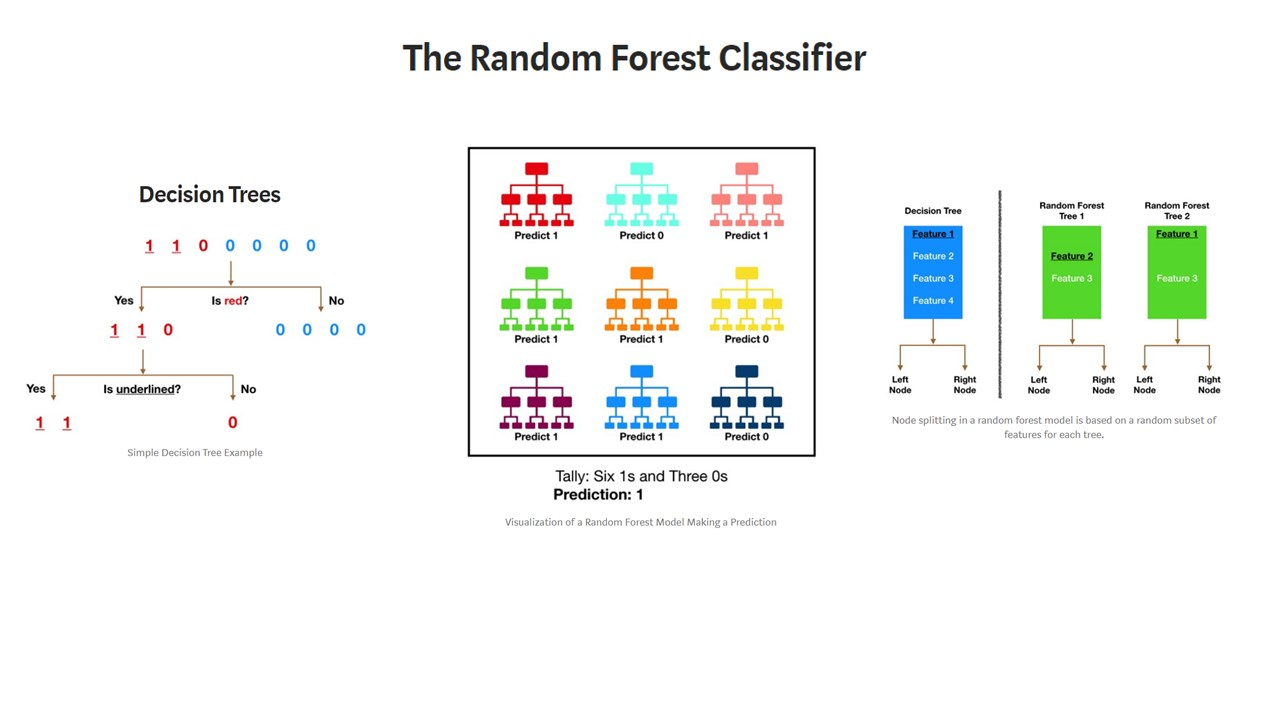


# **4. Dimensionality Reduction: Principal component analysis (PCA)**

In a nutshell, PCA aims to find the directions of maximum variance in highdimensional
data and projects the data onto a new subspace with equal or fewer
dimensions than the original one. The orthogonal axes (principal components) of
the new subspace can be interpreted as the directions of maximum variance given
the constraint that the new feature axes are orthogonal to each other, as illustrated
in the following figure:

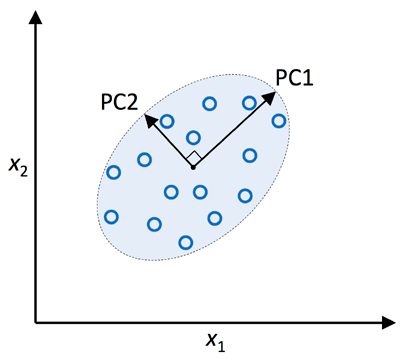

In the preceding figure, X1 and X2 are the original feature axes, and PC1 and PC2 are
the principal components.

In [ ]:
X_train_std.shape

In [ ]:
#To show the explain variance ratio in order for each components
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

print(X_train_pca.shape, X_train_std.shape)

In [ ]:
# Only select the top 2 components: (n_components=2)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

In [ ]:
# Train the model

from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.title('Training Data')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

In [ ]:
#Test the model using testing data

plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.title('Test Data')
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

After we plot the decision regions for the test dataset by executing the preceding code,
we can see that logistic regression performs quite well on this small two-dimensional
feature subspace and only misclassifies a few examples in the test dataset

# **5. Building a Pipeline**

Pipeline allows us to fit a model including an arbitrary number of transformation
steps and apply it to make predictions about new data.

We can think of a Pipeline as a meta-estimator or wrapper around
the individual transformers and estimators. If we call the fit method of Pipeline,
the data will be passed down a series of transformers via fit and transform calls
on these intermediate steps until it arrives at the estimator object (the final element
in a pipeline). The estimator will then be fitted to the transformed training data.

In [ ]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

print(df.head())
print(df.shape)

In [ ]:
#Partitioning X and Y
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

#Partitioning training and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)
    
#Chain the StandardScaler, PCA, and LogisticRegression objects in a pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

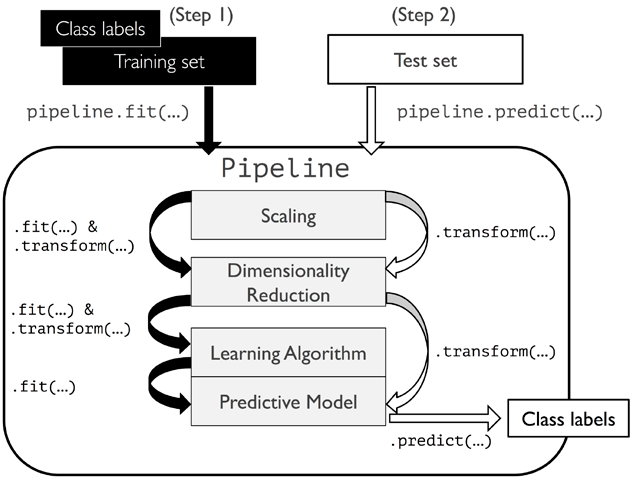

# **6. K-fold Cross-Validation**

In k-fold cross-validation, we randomly split the training dataset into k folds without
replacement, where k – 1 folds are used for the model training, and one fold is used
for performance evaluation. This procedure is repeated k times so that we obtain k
models and performance estimates.

We then calculate the average performance of the models based on the different,
independent test folds to obtain a performance estimate

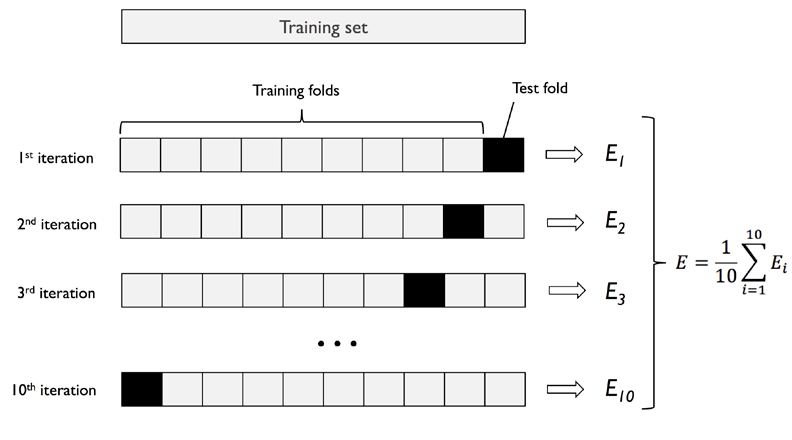

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             n_jobs=1)

print('CV accuracy scores: {}'.format(scores))
print('CV accuracy mean:{} and std:{}'.format(np.mean(scores), np.std(scores)))

# **7. Learning and Validation curves**

If a model is too complex for a given training dataset (there are too many degrees of freedom or parameters in this model) the model tends to overfit the training data and does not generalize well to unseen data. Often, it can help to collect more training examples to reduce the degree of overfitting.

However, in practice, it can often be very expensive or simply not feasible to collect more data. By plotting the model training and validation accuracies as functions of the training dataset size, we can easily detect whether the model suffers from high variance or high bias, and whether the collection of more data could help to address this problem. But before we discuss how to plot learning curves in scikit-learn, let's discuss those two common model issues by walking through the following illustration:

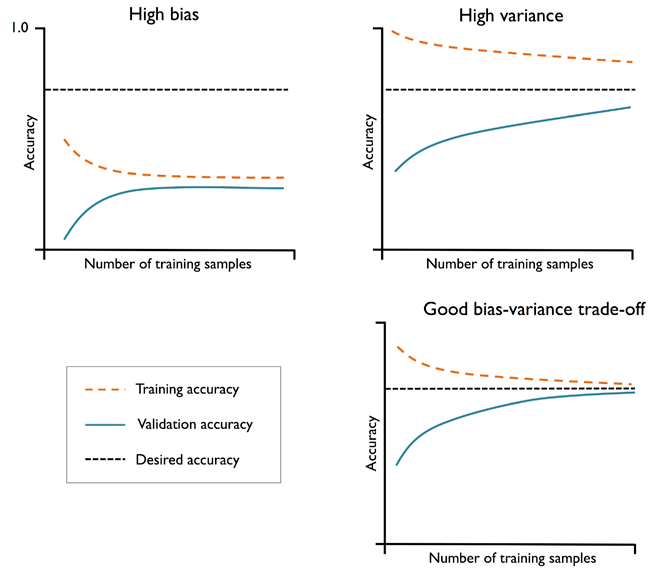

The graph in the upper-left shows a model with high bias. This model has both low
training and cross-validation accuracy, which indicates that it underfits the training
data. Common ways to address this issue are to increase the number of parameters
of the model.

The graph in the upper-right shows a model that suffers from high variance, which
is indicated by the large gap between the training and cross-validation accuracy.
To address this problem of overfitting, we can collect more training data, reduce
the complexity of the model, or increase the regularization parameter



In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.05])
plt.tight_layout()
plt.title('Learning Curve')
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

In [ ]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

# **8. Grid Search**

The grid search approach is quite simple: it's a brute-force exhaustive search
paradigm where we specify a list of values for different hyperparameters, and
the computer evaluates the model performance for each combination to obtain
the optimal combination of values from this set.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

#set the param_grid parameter of GridSearchCV to a list of dictionaries to specify the parameters that we'd want to tune.

# For the linear SVM, we only evaluated the inverse regularization parameter, C; 
param_grid = [{'svc__C': param_range,'svc__kernel': ['linear']},            
#For the RBF kernel SVM, we tuned both the svc__C and svc__gamma
#parameters. Note that the svc__gamma parameter is specific to kernel SVMs.              
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

#initialized a GridSearchCV object from the sklearn model_selection
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, cv=5, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)

# After we used the training data to perform the grid search, we obtained the score
# of the best-performing model via the best_score_ attribute and looked at its
# parameters, which can be accessed via the best_params_ attribute.
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

# **9. Confusion matrix**

A confusion matrix is simply a square matrix that reports the counts of the true
positive (TP), true negative (TN), false positive (FP), and false negative (FN)
predictions of a classifier, as shown in the following figure:

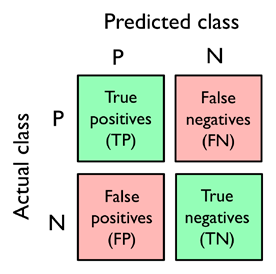

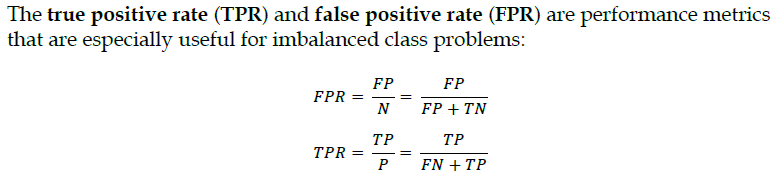

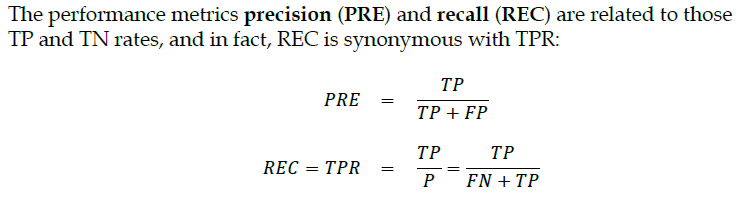


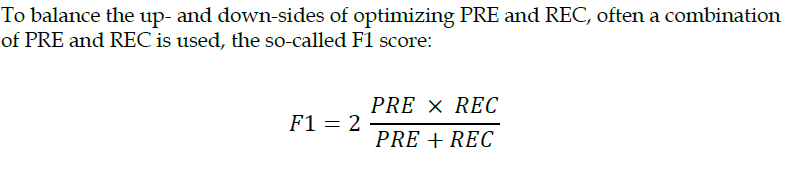


## **9.1 ROC-AUC curves**


Receiver operating characteristic (ROC) graphs are useful tools to select models for
classification based on their performance with respect to the FPR and TPR.

The diagonal of
a ROC graph can be interpreted as random guessing, and classification models that
fall below the diagonal are considered as worse than random guessing. A perfect
classifier would fall into the top-left corner of the graph with a TPR of 1 and an FPR
of 0. Based on the ROC curve, we can then compute the so-called ROC area under
the curve (ROC AUC) to characterize the performance of a classification model.

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()

The
resulting ROC curve indicates that there is a certain degree of variance between the
different folds, and the average ROC AUC (0.76) falls between a perfect score (1.0)
and random guessing (0.5)

## **10. SMOTE**

Class imbalance is a quite common problem when working with real-world
data—examples from one class or multiple classes are over-represented in a dataset.

Synthetic Minority Oversampling
Technique (SMOTE) is the most widely used algorithm for
synthetic training data generation.

https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

In [ ]:
!pip install imbalanced-learn

In [ ]:
import os
os.chdir('sample_data')

In [ ]:
pwd

In [ ]:
import pandas as pd
# Read in "creditcard.csv" data
df = pd.read_csv('creditcard.csv')

# print out shape
print(df.shape)

# print out sample of data
df.tail()
df.dropna(axis=0, inplace=True)

# # check for NaNs
# print(df.info())
# print(list(df))
X = df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']]
y = df['Class']
print(len(y), y.sum())


In [ ]:
df.tail()

In [ ]:
import imblearn
print(imblearn.__version__)

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
X_res, y_res = sm.fit_sample(X, y)

print(X_res.shape, y_res.shape, X.shape, y.shape)

In [ ]:
print([y.sum(), len(y), y.sum()/len(y)])
print([y_res.sum(), len(y_res),y_res.sum()/len(y_res) ])



---

